## Set up the environment

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import os
import io
import tarfile
import datetime

import PIL

import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import RealTimePredictor, json_deserializer
from sagemaker.utils import name_from_base

from fastai.vision import *
from fastai import *

In [6]:
path = Path('data/food/')
path

PosixPath('data/food')

In [7]:
path.ls()

[PosixPath('data/food/healthy'),
 PosixPath('data/food/export.pkl'),
 PosixPath('data/food/test'),
 PosixPath('data/food/junk'),
 PosixPath('data/food/src'),
 PosixPath('data/food/models')]

In [8]:
bs=64

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

/home/ec2-user/SageMaker/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:475: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the folowing unknown labels, the corresponding items have been discarded.
test
  if getattr(ds, 'warn', False): warn(ds.warn)


In [10]:
data.classes

['healthy', 'junk']

In [11]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


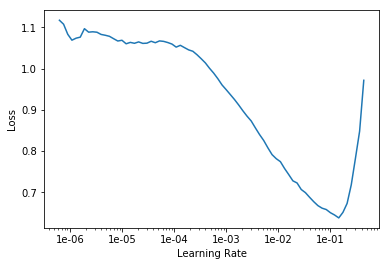

In [106]:
learn.lr_find()
learn.recorder.plot()

In [107]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy
1,0.911222,0.505415,0.791367
2,0.716240,0.323102,0.848921
3,0.562755,0.330406,0.856115
4,0.479116,0.347866,0.841727
5,0.424020,0.366252,0.848921
6,0.367126,0.342529,0.863309
7,0.339173,0.329033,0.863309
8,0.314009,0.328923,0.863309


In [115]:
learn.save('stage-1')

In [116]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.232132,0.386114,0.827338
2,0.200392,0.554611,0.762590
3,0.175063,0.468612,0.841727
4,0.163689,0.324182,0.892086


In [118]:
learn.save('stage-2')

# Local inference

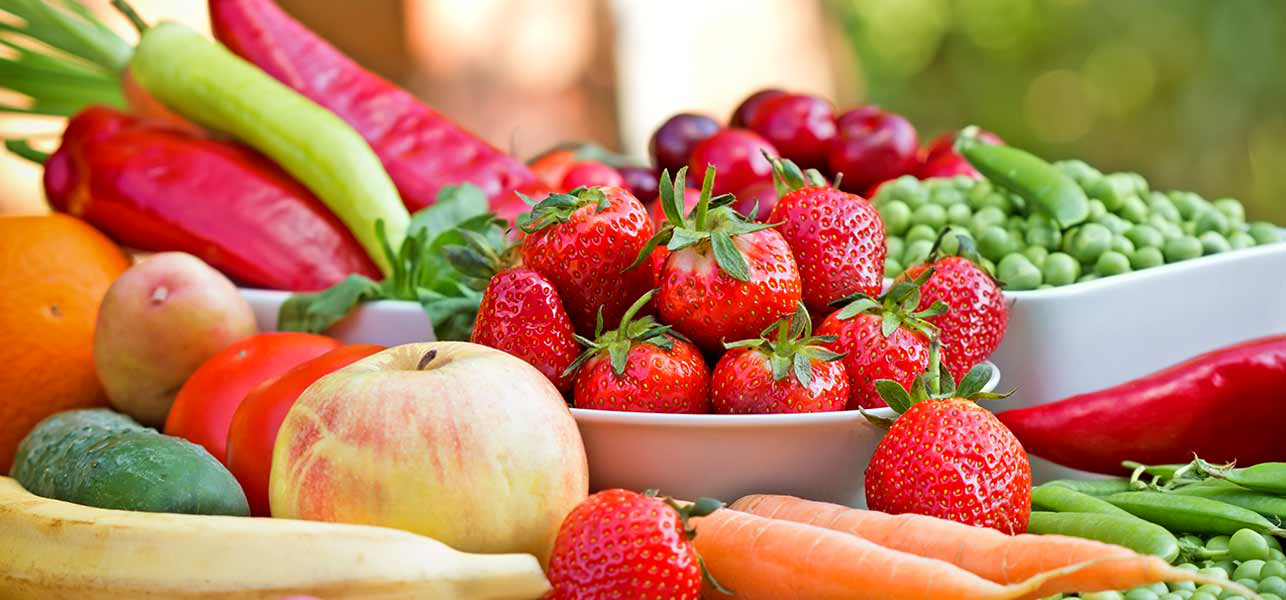

In [80]:
img = open_image(path/'test'/'healthy.jpg')
img

In [12]:
learn.load('stage-2')
data.export()
learn = load_learner(path)

RuntimeError: Invalid magic number; corrupt file?

## Export model and upload to S3

In [38]:
sagemaker_session = sagemaker.Session()

bucket = 'amitmukh-smmodel'
model_name = name_from_base('fastai-food-model')
prefix = f'sagemaker/{model_name}'

role = sagemaker.get_execution_role()

In [39]:
data.export()
learn.save('resnet34')

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

In [40]:
tar_file=path/'models/model.tar.gz'
model_file='resnet34.pth'
data_export_file='export.pkl'

In [41]:
with tarfile.open(tar_file, 'w:gz') as f:
    t = tarfile.TarInfo('models')
    t.type = tarfile.DIRTYPE
    f.addfile(t)
    f.add(path/f'models/{model_file}', arcname=model_file)
    f.add(path/data_export_file, arcname=data_export_file)

In [42]:
model_artefact = sagemaker_session.upload_data(path=str(tar_file), bucket=bucket, key_prefix=prefix)



# Deploy to SageMaker

In [43]:
class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=None, 
                         deserializer=json_deserializer, content_type='image/jpeg')

In [44]:
model=PyTorchModel(model_data=model_artefact, name=name_from_base("fastai-food-model"),
    role=role, framework_version='1.0.0', entry_point='/home/ec2-user/SageMaker/course-v3/nbs/dl1/data/food/src/food.py', predictor_cls=ImagePredictor)

predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-446913493325
INFO:sagemaker:Creating model with name: fastai-food-model-2019-03-11-17-01-14-477
INFO:sagemaker:Creating endpoint with name fastai-food-model-2019-03-11-17-01-14-477


--

KeyboardInterrupt: 

# Doing Inference in Sagemaker Endpoint

In [ ]:
url = <some url of an image to test>
img_bytes = requests.get(url).content
predictor.predict(img_bytes); response